#### Импорт необходимых библиотек

In [ ]:
# !pip install bnlearn # необходимо для задачи 3.7, не реализовано

In [ ]:
# !pip install pgmpy # необходимо для задачи 3.7, не реализовано

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, roc_curve, auc, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBClassifier, XGBRegressor

# необходимо для задачи 3.7, не реализовано
# from pgmpy.models import BayesianNetwork
# from pgmpy.estimators import MaximumLikelihoodEstimator
# from pgmpy.estimators import HillClimbSearch, BicScore
# from pgmpy.inference import VariableElimination
# import bnlearn as bn

from tqdm import tqdm

### Задание 2

#### Задание 2.3

In [ ]:
np.random.seed(43)
n = 1000

# 1. Генерация контрольных переменных (в годах)
X1 = np.random.normal(10, 3, n)
X1 = np.where(X1 < 0.1, 0.1, X1)

# X2: Оценка когнитивных способностей, равномерно от 50 до 100
X2 = np.random.uniform(50, 100, n)

# X3: # Наличие поддержки руководства (1 = есть, 0 = нет)
X3 = np.random.binomial(1, 0.5, n)

# 2. Генерация инструментальной переменной Z (1 = доступно, 0 = нет)
Z = np.random.binomial(1, 0.5, n)

# 3. Генерация переменной воздействия D (Участие в обучении)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

p_D = sigmoid(-4 + 0.05 * X1 + 0.03 * X2 + 0.8 * X3 + 0.7 * Z)
D = np.random.binomial(1, p_D)

# 4. Генерация зависимой переменной Y (Годовой доход, тыс. условных единиц)
epsilon = np.random.normal(0, 3, n)
Y = 20 + 15 * D + 3 * np.sqrt(X1) + 0.2 * X2 + 5 * X3 + 2 * (D * np.log(X2)) + 4 * np.sin(X1) + epsilon

df = pd.DataFrame({
    "X1": X1,
    "X2": X2,
    "X3": X3,
    "Z": Z,
    "D": D,
    "Y": Y
})
df.head()

,X1,X2,X3,Z,D,Y
0,10.772200,80.497711,1,1,1,77.745108
1,7.274556,95.333834,1,0,0,56.363263
2,8.864491,84.450275,0,1,1,74.087863
3,8.395253,89.842752,0,0,1,73.281006
4,12.574220,81.278107,0,1,0,47.247289


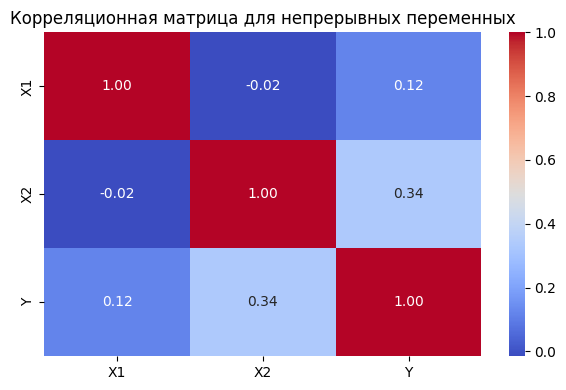

In [ ]:
cont_vars = ["X1", "X2", "Y"]
corr_matrix = df[cont_vars].corr()

# Визуализация корреляционной матрицы с помощью тепловой карты и сохранение изображения
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица для непрерывных переменных")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300)

In [ ]:
# Вычисление описательных статистик для непрерывных переменных
desc_cont = df[cont_vars].agg(['mean', 'std', 'median', 'min', 'max']).T
desc_cont = desc_cont.rename(columns={
    'mean': 'Выборочное среднее',
    'std': 'Выборочное стандартное отклонение',
    'median': 'Медиана',
    'min': 'Минимум',
    'max': 'Максимум'
})
print("\nОписательные статистики для непрерывных переменных:")
desc_cont


Описательные статистики для непрерывных переменных:


,Выборочное среднее,Выборочное стандартное отклонение,Медиана,Минимум,Максимум
X1,10.010451,2.967962,10.010559,0.922780,18.728600
X2,75.936211,14.388167,76.454437,50.067460,99.951006
Y,56.720921,13.671364,51.882183,28.426711,87.307921


In [ ]:
desc_cont_reset = desc_cont.reset_index()
desc_cont_reset.rename(columns={"index": "Переменная"}, inplace=True)
latex_table = desc_cont_reset.to_latex(index=False, float_format="%.2f",
                                       caption="Описательные статистики для непрерывных переменных",
                                       label="tab:desc_cont")
print(latex_table)

\begin{table}
\caption{Описательные статистики для непрерывных переменных}
\label{tab:desc_cont}
\begin{tabular}{lrrrrr}
\toprule
Переменная & Выборочное среднее & Выборочное стандартное отклонение & Медиана & Минимум & Максимум \\
\midrule
X1 & 10.01 & 2.97 & 10.01 & 0.92 & 18.73 \\
X2 & 75.94 & 14.39 & 76.45 & 50.07 & 99.95 \\
Y & 56.72 & 13.67 & 51.88 & 28.43 & 87.31 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
# Для бинарных переменных
bin_vars = ['X3', 'Z', 'D']
def binary_stats(x):
    return pd.Series({
        'Доля единиц': x.mean(),
        'Количество единиц': x.sum()
    })

stats_bin = df[bin_vars].apply(binary_stats)
print("\nОписательные статистики для бинарных переменных:")
stats_bin


Описательные статистики для бинарных переменных:


,X3,Z,D
Доля единиц,0.511,0.501,0.406
Количество единиц,511.000,501.000,406.000


In [ ]:
stats_bin_reset = stats_bin.reset_index()
stats_bin_reset.rename(columns={"index": "Переменная"}, inplace=True)
latex_table = stats_bin_reset.to_latex(index=False, float_format="%.2f",
                                       caption="Описательные статистики для бинарных переменных",
                                       label="tab:stats_bin")
print(latex_table)

\begin{table}
\caption{Описательные статистики для бинарных переменных}
\label{tab:stats_bin}
\begin{tabular}{lrrr}
\toprule
Переменная & X3 & Z & D \\
\midrule
Доля единиц & 0.51 & 0.50 & 0.41 \\
Количество единиц & 511.00 & 501.00 & 406.00 \\
\bottomrule
\end{tabular}
\end{table}



#### Задание 2.4

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

print("Размер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

Размер обучающей выборки: (750, 6)
Размер тестовой выборки: (250, 6)


### Задание 3

#### Задание 3.2

In [ ]:
# Берем X1, X2, X3, Z для предсказания D (первый этап)
features = ["X1", "X2", "X3", "Z"]

X_train = train_df[features]
y_train = train_df["D"]
X_test = test_df[features]
y_test = test_df["D"]

# Для логистической регрессии масштабирование признаков критично
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Функция для оценки модели: точность на обучающей выборке, тестовой выборке и через 5-кратную CV
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    cv_acc = np.mean(cross_val_score(model, X_train, y_train, cv=5))
    return round(train_acc, 2), round(test_acc, 2), round(cv_acc, 2)

# Модель 1: Логистическая регрессия с исходным гиперпараметром C=1
lr = LogisticRegression(C=1, solver='lbfgs', max_iter=1000, random_state=42)
lr_train, lr_test, lr_cv = evaluate_model(lr, X_train, y_train, X_test, y_test)

# Модель 2: k-NN с исходным гиперпараметром k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn_train, knn_test, knn_cv = evaluate_model(knn, X_train, y_train, X_test, y_test)

# Модель 3: XGBoost с исходными гиперпараметрами: n_estimators=30, learning_rate=0.1, max_depth=3
xgb = XGBClassifier(n_estimators=30, learning_rate=0.1, max_depth=3, eval_metric='logloss', random_state=42)
xgb_train, xgb_test, xgb_cv = evaluate_model(xgb, X_train, y_train, X_test, y_test)

results_initial = pd.DataFrame({
    "Method": ["Logistic Regression", "k-NN", "XGBoost"],
    "Train Accuracy": [lr_train, knn_train, xgb_train],
    "Test Accuracy": [lr_test, knn_test, xgb_test],
    "CV Accuracy": [lr_cv, knn_cv, xgb_cv]
})
print("Сравнение качества прогнозов на произвольных параметрах")
results_initial

Сравнение качества прогнозов на произвольных параметрах


,Method,Train Accuracy,Test Accuracy,CV Accuracy
0,Logistic Regression,0.65,0.60,0.64
1,k-NN,0.70,0.53,0.55
2,XGBoost,0.69,0.59,0.61


In [ ]:
latex_table = results_initial.to_latex(index=False, float_format="%.2f",
                                       caption="Классификация с базовыми параметрами",
                                       label="tab:no_tuning_accuracy")
print(latex_table)

\begin{table}
\caption{Классификация с базовыми параметрами}
\label{tab:no_tuning_accuracy}
\begin{tabular}{lrrr}
\toprule
Method & Train Accuracy & Test Accuracy & CV Accuracy \\
\midrule
Logistic Regression & 0.65 & 0.60 & 0.64 \\
k-NN & 0.70 & 0.53 & 0.55 \\
XGBoost & 0.69 & 0.59 & 0.61 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 3.3

In [ ]:
# Для логистической регрессии: подбираем параметр C
param_grid_lr = {'C': [0.1, 0.5, 1, 2, 5]}
grid_lr = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
                       param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)
lr_best_acc = grid_lr.best_estimator_
lr_tuned_train, lr_tuned_test, lr_tuned_cv = evaluate_model(lr_best_acc, X_train_scaled, y_train, X_test_scaled, y_test)

# Для k-NN: подбираем число соседей
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
knn_best_acc = grid_knn.best_estimator_
knn_tuned_train, knn_tuned_test, knn_tuned_cv = evaluate_model(knn_best_acc, X_train_scaled, y_train, X_test_scaled, y_test)

# Для XGBoost: подбираем n_estimators, learning_rate, max_depth
param_grid_xgb = {'n_estimators': [30, 50, 100, 200],
                  'learning_rate': [0.05, 0.1, 0.2],
                  'max_depth': [3, 5, 7]}
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42),
                        param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train_scaled, y_train)
xgb_best_acc = grid_xgb.best_estimator_
xgb_tuned_train, xgb_tuned_test, xgb_tuned_cv = evaluate_model(xgb_best_acc, X_train_scaled, y_train, X_test_scaled, y_test)

xgb_params_str = ', '.join([f"{param_name}={param_val}" for param_name, param_val in grid_xgb.best_params_.items()])

results_tuned = pd.DataFrame({
    "Method": ["Logistic Regression", "k-NN", "XGBoost"],
    "Init Hyperparams": ["C=1", "k=5", "n_estimators=30, lr=0.1, max_depth=3"],
    "Tuned Hyperparams": [f"C={grid_lr.best_params_['C']}",
                                f"k={grid_knn.best_params_['n_neighbors']}",
                                xgb_params_str],
    "CV Acc Init": [lr_cv, knn_cv, xgb_cv],
    "CV Acc Tuned": [lr_tuned_cv, knn_tuned_cv, xgb_tuned_cv],
    "Test Acc Init": [lr_test, knn_test, xgb_test],
    "Test Acc Tuned": [lr_tuned_test, knn_tuned_test, xgb_tuned_test]
})
print("\nTuned results:")
results_tuned


Tuned results:


,Method,Init Hyperparams,Tuned Hyperparams,CV Acc Init,CV Acc Tuned,Test Acc Init,Test Acc Tuned
0,Logistic Regression,C=1,C=1,0.64,0.64,0.60,0.60
1,k-NN,k=5,k=9,0.55,0.60,0.53,0.58
2,XGBoost,"n_estimators=30, lr=0.1, max_depth=3","learning_rate=0.05, max_depth=3, n_estimators=30",0.61,0.63,0.59,0.56


In [ ]:
latex_table = results_tuned.to_latex(index=False, float_format="%.2f",
                                       caption="Оптимальные значения гиперпараметров (ACC)",
                                       label="tab:tuning_accuracy")
print(latex_table)

\begin{table}
\caption{Оптимальные значения гиперпараметров (ACC)}
\label{tab:tuning_accuracy}
\begin{tabular}{lllrrrr}
\toprule
Method & Init Hyperparams & Tuned Hyperparams & CV Acc Init & CV Acc Tuned & Test Acc Init & Test Acc Tuned \\
\midrule
Logistic Regression & C=1 & C=1 & 0.64 & 0.64 & 0.60 & 0.60 \\
k-NN & k=5 & k=9 & 0.55 & 0.60 & 0.53 & 0.58 \\
XGBoost & n_estimators=30, lr=0.1, max_depth=3 & learning_rate=0.05, max_depth=3, n_estimators=30 & 0.61 & 0.63 & 0.59 & 0.56 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 3.4

In [ ]:
# Функция для оценки модели по F1-мере
def evaluate_model_f1(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    cv_f1 = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='f1'))
    return round(train_f1, 2), round(test_f1, 2), round(cv_f1, 2)

# Исходные модели
lr = LogisticRegression(C=1, solver='lbfgs', max_iter=1000, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
xgb = XGBClassifier(n_estimators=30, learning_rate=0.1, max_depth=3,
                    eval_metric='logloss', random_state=42)

# Оценка по F1-мере
lr_train_f1, lr_test_f1, lr_cv_f1 = evaluate_model_f1(lr, X_train_scaled, y_train, X_test_scaled, y_test)
knn_train_f1, knn_test_f1, knn_cv_f1 = evaluate_model_f1(knn, X_train_scaled, y_train, X_test_scaled, y_test)
xgb_train_f1, xgb_test_f1, xgb_cv_f1 = evaluate_model_f1(xgb, X_train_scaled, y_train, X_test_scaled, y_test)

results_initial_f1 = pd.DataFrame({
    "Method": ["Logistic Regression", "k-NN", "XGBoost"],
    "Train F1": [lr_train_f1, knn_train_f1, xgb_train_f1],
    "Test F1": [lr_test_f1, knn_test_f1, xgb_test_f1],
    "CV F1": [lr_cv_f1, knn_cv_f1, xgb_cv_f1]
})
print("Initial results (F1):")
results_initial_f1

Initial results (F1):


,Method,Train F1,Test F1,CV F1
0,Logistic Regression,0.47,0.40,0.47
1,k-NN,0.63,0.48,0.44
2,XGBoost,0.55,0.40,0.44


In [ ]:
# Подбор гиперпараметров по F1-мере
f1_scorer = make_scorer(f1_score)

# Логистическая регрессия
param_grid_lr = {'C': [0.1, 0.5, 1, 2, 5]}
grid_lr = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42),
                       param_grid_lr, cv=5, scoring=f1_scorer)
grid_lr.fit(X_train_scaled, y_train)
lr_best_f1 = grid_lr.best_estimator_
lr_best_train_f1, lr_best_test_f1, lr_best_cv_f1 = evaluate_model_f1(lr_best_f1, X_train_scaled, y_train, X_test_scaled, y_test)

# k-NN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring=f1_scorer)
grid_knn.fit(X_train_scaled, y_train)
knn_best_f1 = grid_knn.best_estimator_
knn_best_train_f1, knn_best_test_f1, knn_best_cv_f1 = evaluate_model_f1(knn_best_f1, X_train_scaled, y_train, X_test_scaled, y_test)

# XGBoost
param_grid_xgb = {
    'n_estimators': [30, 50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42),
                        param_grid_xgb, cv=5, scoring=f1_scorer)
grid_xgb.fit(X_train_scaled, y_train)
xgb_best_f1 = grid_xgb.best_estimator_
xgb_best_train_f1, xgb_best_test_f1, xgb_best_cv_f1 = evaluate_model_f1(xgb_best_f1, X_train_scaled, y_train, X_test_scaled, y_test)

xgb_params_str = ', '.join([f"{param_name}={param_val}" for param_name, param_val in grid_xgb.best_params_.items()])

results_tuned_f1 = pd.DataFrame({
    "Method": ["Logistic Regression", "k-NN", "XGBoost"],
    "Init Hyperparams": ["C=1", "k=5", "n_estimators=30, lr=0.1, max_depth=3"],
    "Tuned Hyperparams": [
        f"C={grid_lr.best_params_['C']}",
        f"k={grid_knn.best_params_['n_neighbors']}",
        xgb_params_str
    ],
    "CV F1 Init": [lr_cv_f1, knn_cv_f1, xgb_cv_f1],
    "CV F1 Tuned": [lr_best_cv_f1, knn_best_cv_f1, xgb_best_cv_f1],
    "Test F1 Init": [lr_test_f1, knn_test_f1, xgb_test_f1],
    "Test F1 Tuned": [lr_best_test_f1, knn_best_test_f1, xgb_best_test_f1]
})
print("\nTuned results (F1):")
results_tuned_f1


Tuned results (F1):


,Method,Init Hyperparams,Tuned Hyperparams,CV F1 Init,CV F1 Tuned,Test F1 Init,Test F1 Tuned
0,Logistic Regression,C=1,C=2,0.47,0.47,0.40,0.40
1,k-NN,k=5,k=9,0.44,0.45,0.48,0.43
2,XGBoost,"n_estimators=30, lr=0.1, max_depth=3","learning_rate=0.2, max_depth=5, n_estimators=200",0.44,0.51,0.40,0.42


In [ ]:
latex_table = results_tuned_f1.to_latex(index=False, float_format="%.2f",
                                       caption="Оптимальные значения гиперпараметров (F1)",
                                       label="tab:tuning_f1")
print(latex_table)

\begin{table}
\caption{Оптимальные значения гиперпараметров (F1)}
\label{tab:tuning_f1}
\begin{tabular}{lllrrrr}
\toprule
Method & Init Hyperparams & Tuned Hyperparams & CV F1 Init & CV F1 Tuned & Test F1 Init & Test F1 Tuned \\
\midrule
Logistic Regression & C=1 & C=2 & 0.47 & 0.47 & 0.40 & 0.40 \\
k-NN & k=5 & k=9 & 0.44 & 0.45 & 0.48 & 0.43 \\
XGBoost & n_estimators=30, lr=0.1, max_depth=3 & learning_rate=0.2, max_depth=5, n_estimators=200 & 0.44 & 0.51 & 0.40 & 0.42 \\
\bottomrule
\end{tabular}
\end{table}



#### Задание 3.5

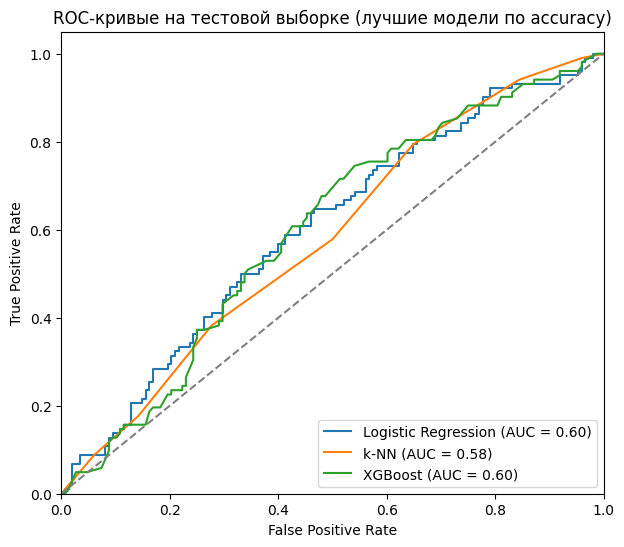

In [ ]:
def plot_roc_curves(best_models, X_test, y_test):
    """
    best_models — список кортежей (model, label), где:
       model — обученная лучшая модель по accuracy,
       label — строка с названием модели.
    Строит ROC-кривые для каждой модели на тестовой выборке и выводит AUC.
    """
    plt.figure(figsize=(7, 6))

    for model, label in best_models:
        # Предсказываем вероятности принадлежности к классу 1
        y_proba = model.predict_proba(X_test)[:, 1]

        # Считаем точки ROC-кривой
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Строим ROC-кривую, выводим AUC с точностью до двух знаков
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

    # Линия для случайного классификатора
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые на тестовой выборке (лучшие модели по accuracy)')
    plt.legend(loc="lower right")
    plt.show()

# Формируем список моделей для визуализации
best_models_acc = [
    (lr_best_acc, "Logistic Regression"),
    (knn_best_acc, "k-NN"),
    (xgb_best_acc, "XGBoost")
]

# Строим ROC-кривые и выводим AUC
plot_roc_curves(best_models_acc, X_test_scaled, y_test)

#### Задача 3.6

In [ ]:
# 1. Задаём стоимости (прибыли/убытки) для различных исходов
costs = {
    "TP": 100,
    "FP": -50,
    "FN": -30,
    "TN": 0
}

def compute_profit(y_true, y_proba, threshold, costs):
    """
    Вычисляет прибыль (суммарную) при заданном пороге.
    y_true: истинные метки (0 или 1)
    y_proba: вероятности принадлежности к классу 1
    threshold: порог классификации
    costs: словарь вида {"TP": ..., "FP": ..., "FN": ..., "TN": ...}
    """
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    profit = (tp * costs["TP"] +
              fp * costs["FP"] +
              fn * costs["FN"] +
              tn * costs["TN"])
    return profit

def find_best_threshold(model, X_train, y_train, costs, n_thresholds=101):
    """
    Перебирает n_thresholds порогов от 0 до 1, вычисляет прибыль на train,
    возвращает (best_threshold, best_profit).
    """
    y_proba = model.predict_proba(X_train)[:, 1]

    thresholds = np.linspace(0, 1, n_thresholds)
    best_threshold = 0.0
    best_profit = -np.inf

    for th in thresholds:
        profit = compute_profit(y_train, y_proba, th, costs)
        if profit > best_profit:
            best_profit = profit
            best_threshold = th
    return best_threshold, best_profit

def evaluate_model_profit(model, X_train, y_train, X_test, y_test, costs):
    """
    1) Находим лучший порог на обучающей выборке, максимизирующий прибыль.
    2) Считаем прибыль на тестовой выборке при этом пороге.
    3) Возвращаем (best_threshold, train_profit, test_profit).
    """
    best_th, best_train_profit = find_best_threshold(model, X_train, y_train, costs)

    # Прибыль на тесте при best_th
    y_test_proba = model.predict_proba(X_test)[:, 1]
    test_profit = compute_profit(y_test, y_test_proba, best_th, costs)

    return best_th, best_train_profit, test_profit

def compute_auc(model, X_test, y_test):
    """
    Вычисляет AUC на тестовой выборке.
    """
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    return auc(fpr, tpr)

results = []

for model, label in best_models_acc:
    # 1. Находим лучший порог и прибыль на train
    best_th, train_profit, test_profit = evaluate_model_profit(model,
                                                               X_train_scaled, y_train,
                                                               X_test_scaled, y_test,
                                                               costs)
    # 2. Считаем AUC на тесте
    model_auc = compute_auc(model, X_test_scaled, y_test)

    results.append({
        "Model": label,
        "AUC Test": round(model_auc, 2),
        "Best Threshold": round(best_th, 2),
        "Train Profit": int(train_profit),
        "Test Profit": int(test_profit)
    })

profit_auc = pd.DataFrame(results)
profit_auc

,Model,AUC Test,Best Threshold,Train Profit,Test Profit
0,Logistic Regression,0.60,0.31,10530,2480
1,k-NN,0.58,0.12,10800,3170
2,XGBoost,0.60,0.34,12390,2790


In [ ]:
latex_table = profit_auc.to_latex(index=False, float_format="%.2f",
                                       caption="Прибыли и AUC моделей",
                                       label="tab:profit_auc")
print(latex_table)

\begin{table}
\caption{Прибыли и AUC моделей}
\label{tab:profit_auc}
\begin{tabular}{lrrrr}
\toprule
Model & AUC Test & Best Threshold & Train Profit & Test Profit \\
\midrule
Logistic Regression & 0.60 & 0.31 & 10530 & 2480 \\
k-NN & 0.58 & 0.12 & 10800 & 3170 \\
XGBoost & 0.60 & 0.34 & 12390 & 2790 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 3.7 Не реализовано

In [ ]:
# data['X1'] = pd.cut(data['X1'], bins=3, labels=['low', 'mid', 'high'])
# data['X2'] = pd.cut(data['X2'], bins=2, labels=['low', 'high'])

In [ ]:
# user_edges = [('Z', 'D'), ('X1', 'D'), ('X2', 'D'), ('X3', 'D')]
# user_dag = bn.make_DAG(user_edges)

# # 4. Обучение с запретом связей D -> *
# fixed_edges = [
#     ('D', 'Z'), ('D', 'X1'), ('D', 'X2'), ('D', 'X3')  # Все запрещенные связи
# ]

# train, test = train_test_split(data, test_size=0.3, random_state=42)

# # Обучение структуры
# model_learned = bn.structure_learning.fit(
#     train,
#     methodtype='hc',
#     scoretype='bic',
#     fixed_edges=fixed_edges,  # Правильный параметр
#     max_indegree=2
# )

# # Обучение экспертной модели
# model_user = bn.parameter_learning.fit(user_dag, train, methodtype='bayes')

# # 5. Прогнозирование
# def predict_d(model, data):
#     return bn.predict(model, data[['Z','X1','X2','X3']])['D'].astype(int)

# print(f"Точность экспертного DAG: {accuracy_score(test['D'], predict_d(model_user, test)):.2f}")
# print(f"Точность обученного DAG: {accuracy_score(test['D'], predict_d(model_learned, test)):.2f}")

### Задача 4

#### Задача 4.1

In [ ]:
features = ["X1", "X2", "X3"]

X_train = train_df[features]
y_train = train_df["Y"]
X_test = test_df[features]
y_test = test_df["Y"]

# Масштабирование признаков для линейных моделей
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

#### Задание 4.2

In [ ]:
# Инициализируем модели с произвольными гиперпараметрами
knn = KNeighborsRegressor(n_neighbors=5)
xgb = XGBRegressor(n_estimators=30, learning_rate=0.1, max_depth=3, random_state=42)
rf  = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)

models = {
    "k-NN": knn,
    "XGBoost": xgb,
    "RandomForest": rf
}

results = []

for name, model in models.items():
    # Обучаем модель на train
    model.fit(X_train_scaled, y_train)

    # Предсказания на train/test
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test  = model.predict(X_test_scaled)

    # RMSE и MAPE на train/test
    rmse_train = rmse(y_train, y_pred_train)
    rmse_test  = rmse(y_test, y_pred_test)
    mape_train = mape(y_train, y_pred_train)
    mape_test  = mape(y_test, y_pred_test)

    # Кросс-валидация (только на train)
    cv_rmse_scores = cross_val_score(
        model, X_train_scaled, y_train,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    cv_rmse = -cv_rmse_scores.mean()

    cv_mape_scores = cross_val_score(
        model, X_train_scaled, y_train,
        scoring='neg_mean_absolute_percentage_error',
        cv=5
    )
    cv_mape = -cv_mape_scores.mean()

    results.append({
        "Model": name,
        "RMSE (train)": round(rmse_train, 3),
        "RMSE (test)": round(rmse_test, 3),
        "CV RMSE": round(cv_rmse, 3),
        "MAPE (train)": round(mape_train, 3),
        "MAPE (test)": round(mape_test, 3),
        "CV MAPE": round(cv_mape, 3)
    })

regression_results = pd.DataFrame(results)
regression_results

,Model,RMSE (train),RMSE (test),CV RMSE,MAPE (train),MAPE (test),CV MAPE
0,k-NN,10.232,13.898,12.405,0.155,0.216,0.191
1,XGBoost,10.862,12.592,11.888,0.179,0.211,0.195
2,RandomForest,10.319,12.973,11.886,0.166,0.213,0.191


In [ ]:
latex_table = regression_results.to_latex(index=False, float_format="%.2f",
                                       caption="Регрессия с базовыми параметрами",
                                       label="tab:no_tuning_linear")
print(latex_table)

\begin{table}
\caption{Регрессия с базовыми параметрами}
\label{tab:no_tuning_linear}
\begin{tabular}{lrrrrrr}
\toprule
Model & RMSE (train) & RMSE (test) & CV RMSE & MAPE (train) & MAPE (test) & CV MAPE \\
\midrule
k-NN & 10.23 & 13.90 & 12.40 & 0.15 & 0.22 & 0.19 \\
XGBoost & 10.86 & 12.59 & 11.89 & 0.18 & 0.21 & 0.20 \\
RandomForest & 10.32 & 12.97 & 11.89 & 0.17 & 0.21 & 0.19 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 4.3

In [ ]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring=rmse_scorer)
grid_knn.fit(X_train, y_train)
knn_best = grid_knn.best_estimator_

# 4.2. XGBoost
param_grid_xgb = {
    'n_estimators': [30, 50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring=rmse_scorer)
grid_xgb.fit(X_train, y_train)
xgb_best = grid_xgb.best_estimator_

# 4.3. RandomForest
param_grid_rf = {
    'n_estimators': [30, 50, 100, 200],
    'max_depth': [3, 5, 7]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring=rmse_scorer)
grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_

# Собираем "best" модели
models_tuned = {
    "k-NN": knn_best,
    "XGBoost": xgb_best,
    "RandomForest": rf_best
}

models_init = {
    "k-NN": 'n_neighbors=5',
    "XGBoost": 'n_estimators=30, learning_rate=0.1, max_depth=3',
    "RandomForest": 'n_estimators=50, max_depth=5'
}

def evaluate_model_rmse(model, X_train, y_train, X_test, y_test):
    # CV RMSE (5 фолдов) через cross_val_score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores.mean()  # значения будут отрицательными (greater_is_better=False)

    # Обучаем модель и оцениваем на тесте
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_rmse = rmse(y_test, y_pred_test)

    return cv_rmse, test_rmse

# Считаем RMSE (tuned) для каждой модели
tuned_results = {}
for name, model in models_tuned.items():
    cv_rmse_tuned, test_rmse_tuned = evaluate_model_rmse(model, X_train, y_train, X_test, y_test)
    tuned_results[name] = {
        "CV RMSE (tuned)": round(cv_rmse_tuned, 2),
        "Test RMSE (tuned)": round(test_rmse_tuned, 2)
    }
    if name == "RandomForest":
        tuned_results[name]["best_params"] = grid_rf.best_params_
    if name == "k-NN":
        tuned_results[name]["best_params"] = grid_knn.best_params_
    else:
        tuned_results[name]["best_params"] = grid_xgb.best_params_

# Формируем итоговую таблицу
rows = []
for name in ["k-NN", "XGBoost", "RandomForest"]:
    init_hparams = models_init[name]
    tuned_hparams = tuned_results[name]["best_params"]

    rows.append({
        "Model": name,
        "Init Hyperparams": init_hparams,
        "Tuned Hyperparams": tuned_hparams,
        "CV RMSE Init": regression_results[regression_results['Model'] == name]["CV RMSE"].iloc[0],
        "CV RMSE Tuned": tuned_results[name]["CV RMSE (tuned)"],
        "Test RMSE Init": regression_results[regression_results['Model'] == name]["RMSE (test)"].iloc[0],
        "Test RMSE Tuned": tuned_results[name]["Test RMSE (tuned)"]
    })

regression_results_tuned = pd.DataFrame(rows)
regression_results_tuned = regression_results_tuned[[
    "Model",
    "Init Hyperparams",
    "Tuned Hyperparams",
    "CV RMSE Init",
    "CV RMSE Tuned",
    "Test RMSE Init",
    "Test RMSE Tuned"
]]
regression_results_tuned

Выходные данные были обрезаны до нескольких последних строк (5000).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
 

,Model,Init Hyperparams,Tuned Hyperparams,CV RMSE Init,CV RMSE Tuned,Test RMSE Init,Test RMSE Tuned
0,k-NN,n_neighbors=5,"{'n_neighbors': 3, 'weights': 'uniform'}",12.405,13.58,13.898,14.10
1,XGBoost,"n_estimators=30, learning_rate=0.1, max_depth=3","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",11.888,11.95,12.592,12.59
2,RandomForest,"n_estimators=50, max_depth=5","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",11.886,11.86,12.973,12.80


In [ ]:
latex_table = regression_results_tuned.to_latex(index=False, float_format="%.2f",
                                       caption="Регрессия с подобранными параметрами",
                                       label="tab:tuning_linear")
print(latex_table)

\begin{table}
\caption{Регрессия с подобранными параметрами}
\label{tab:tuning_linear}
\begin{tabular}{lllrrrr}
\toprule
Model & Init Hyperparams & Tuned Hyperparams & CV RMSE Init & CV RMSE Tuned & Test RMSE Init & Test RMSE Tuned \\
\midrule
k-NN & n_neighbors=5 & {'n_neighbors': 3, 'weights': 'uniform'} & 12.40 & 13.58 & 13.90 & 14.10 \\
XGBoost & n_estimators=30, learning_rate=0.1, max_depth=3 & {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30} & 11.89 & 11.95 & 12.59 & 12.59 \\
RandomForest & n_estimators=50, max_depth=5 & {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 30} & 11.89 & 11.86 & 12.97 & 12.80 \\
\bottomrule
\end{tabular}
\end{table}



### Задача 5

#### Задача 5.1

In [ ]:
import math

def reconstruct_potential_outcomes(df):
    """
    Восстанавливает Y(0) и Y(1) с учётом случайной ошибки eps

    Формула генерации:
      Y = 20 + 15*D + 3*sqrt(X1) + 0.2*X2 + 0.5*X3
          + 2*(D*ln(X2)) + 4*sin(X1) + eps

    Тогда:
      Y(0) = 20 + 3*sqrt(X1) + 0.2*X2 + 0.5*X3 + 4*sin(X1) + eps
      Y(1) = Y(0) + 15 + 2*ln(X2).

    Предполагается X2>0, чтобы ln(X2) был определён.

    Итог: добавляются колонки Y0, Y1.
    """
    # Инициализируем новые колонки
    df["Y0"] = np.nan
    df["Y1"] = np.nan

    for i in range(len(df)):
        x1 = df.loc[i, "X1"]
        x2 = df.loc[i, "X2"]
        x3 = df.loc[i, "X3"]
        d  = df.loc[i, "D"]
        y_obs = df.loc[i, "Y"]

        det_part = 20 + 3*np.sqrt(x1) + 0.2*x2 + 0.5*x3 + 4*np.sin(x1)

        if d == 1:
            y0_i = y_obs - (15 + 2*np.log(x2))
            y1_i = y0_i + 15 + 2*np.log(x2)
        else:
            y0_i = y_obs
            y1_i = y0_i + 15 + 2*math.log(x2)

        df.loc[i, "Y0"] = y0_i
        df.loc[i, "Y1"] = y1_i

    return df
df_reconstructed = reconstruct_potential_outcomes(df)
df_reconstructed

,X1,X2,X3,Z,D,Y,Y0,Y1
0,10.772200,80.497711,1,1,1,77.745108,53.968651,77.745108
1,7.274556,95.333834,1,0,0,56.363263,56.363263,80.478033
2,8.864491,84.450275,0,1,1,74.087863,50.215537,74.087863
3,8.395253,89.842752,0,0,1,73.281006,49.284884,73.281006
4,12.574220,81.278107,0,1,0,47.247289,47.247289,71.043042
...,...,...,...,...,...,...,...,...
995,10.245190,85.649872,0,1,0,39.038849,39.038849,62.939384
996,10.671428,50.564128,0,0,0,34.779818,34.779818,57.626303
997,9.245066,76.933295,1,0,0,54.154750,54.154750,77.840627
998,5.610954,71.993519,1,0,1,69.744496,46.191344,69.744496


#### Задача 5.2

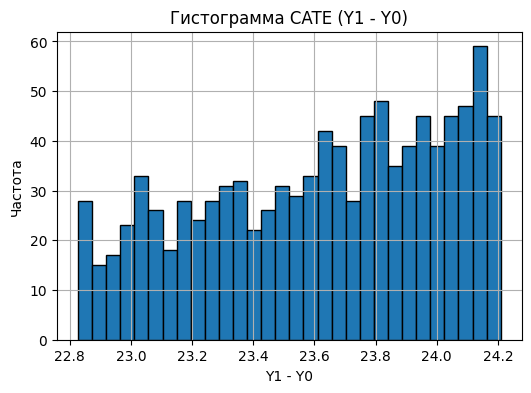

,Effect,Value
0,ATE,23.622253
1,LATE,23.613939


In [ ]:
def effects_of_exposure(df):
    """
    Формула подсчета взяты из лекции 6
    1) Считает ATE = mean(Y1 - Y0).
    2) Строит гистограмму CATE (tau_i = Y1 - Y0).
    3) Считает LATE среди 'собладателей' (D == Z).
    4) Выводит таблицу результатов (ATE, LATE).
    """

    # 1) ATE
    df["tau"] = df["Y1"] - df["Y0"]
    ATE = df["tau"].mean()

    # 2) Гистограмма CATE
    plt.figure(figsize=(6,4))
    df["tau"].hist(bins=30, edgecolor='black')
    plt.title("Гистограмма CATE (Y1 - Y0)")
    plt.xlabel("Y1 - Y0")
    plt.ylabel("Частота")
    plt.show()

    # 3) LATE
    # Соблюдатели: те, у кого D == Z
    compliers = df[df["D"] == df["Z"]]
    LATE = (compliers["Y1"] - compliers["Y0"]).mean()

    # 5) Итоговая таблица
    results = pd.DataFrame({
        "Effect": ["ATE", "LATE"],
        "Value": [ATE, LATE]
    })

    return df, results

df_reconstructed, effects = effects_of_exposure(df_reconstructed)
effects

In [ ]:
latex_table = effects.to_latex(index=False, float_format="%.2f",
                                       caption="Эффекты воздействия",
                                       label="tab:effects_of_exposure")
print(latex_table)

\begin{table}
\caption{Эффекты воздействия}
\label{tab:effects_of_exposure}
\begin{tabular}{lr}
\toprule
Effect & Value \\
\midrule
ATE & 23.62 \\
LATE & 23.61 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 5.3

In [ ]:
Y_treated = df_reconstructed.loc[df["D"]==1, "Y"]
Y_control = df_reconstructed.loc[df["D"]==0, "Y"]

effect_naive = Y_treated.mean() - Y_control.mean()
print("Naive difference in means =", effect_naive)

Naive difference in means = 25.393210459782765


#### Задача 5.4

In [ ]:
# фиксируем лучший регрессор и классификатор из использованных ранее
# в данном случае из классификаторов лучше брать логистическую регрессию вместо k-NN, поскольку ее accuracy было выше (здесь эта метрика важнее)
# best_regressor = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
# best_classifier_profit = KNeighborsClassifier(n_neighbors=9)
# best_classifier_auc = LogisticRegression(C=2, random_state=42)

In [ ]:
def estimate_ate_ols(df, x_cols=['X1', 'X2', 'X3'], y_col="Y", d_col="D"):
    """
    Оценивает средний эффект воздействия (ATE) методом наименьших квадратов (OLS).

    Предполагается, что модель задаётся как:
        Y = alpha + tau * D + f(X) + error
    где D — бинарная переменная (0/1),
    X — вектор ковариат (x_cols),
    tau — искомый коэффициент (ATE).

    Шаги:
      1) Формируем матрицу признаков, включающую столбец D и ковариаты X.
      2) Обучаем LinearRegression на (XD -> Y).
      3) Возвращаем коэффициент при D, который интерпретируется как оценка ATE.
    """
    # 1) Извлекаем массивы
    X = df[x_cols].values
    D = df[d_col].values
    Y = df[y_col].values

    # 2) Формируем матрицу признаков: [D, X]
    #    Т.е. первый столбец = D, остальные столбцы = X
    XD = np.column_stack([D, X])

    # 3) Обучаем линейную регрессию: Y ~ alpha + tau*D + f(X)
    model = LinearRegression()
    model.fit(XD, Y)

    # Коэффициенты модели:
    # model.coef_[0] — коэффициент при D
    tau_ols = model.coef_[0]

    return tau_ols

ate_ols = estimate_ate_ols(df)
print(f"OLS ATE: {ate_ols:.2f}")

OLS ATE: 23.62


In [ ]:
def estimate_ate_conditional_means(
    df,
    model_0,
    model_1,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D"
):
    """
    Оценивает средний эффект воздействия (ATE) методом условных математических ожиданий.
    Суть метода:

      1) Разделить выборку на две подвыборки:
         - D=0 (контроль),
         - D=1 (тreatment).
      2) Обучить две отдельные модели на каждой из этих подвыборок:
         - model_0: аппроксимирует m0(x) = E[Y | D=0, X=x]
         - model_1: аппроксимирует m1(x) = E[Y | D=1, X=x]
      3) Для всей выборки (n объектов) вычислить:
         - m0_i = model_0(X_i)
         - m1_i = model_1(X_i)
      4) Оценка ATE = среднее (m1_i - m0_i).
    """

    # 1) Разделяем выборку на две подвыборки: D=0 и D=1
    df0 = df[df[d_col] == 0]
    df1 = df[df[d_col] == 1]

    X0 = df0[x_cols].values
    Y0 = df0[y_col].values

    X1 = df1[x_cols].values
    Y1 = df1[y_col].values

    # 2) Обучаем две модели
    model_0.fit(X0, Y0)
    model_1.fit(X1, Y1)

    # 3) Предсказываем m0(X_i) и m1(X_i) для всей выборки
    X_all = df[x_cols].values

    m0_all = model_0.predict(X_all)  # E[Y|D=0, X_i]
    m1_all = model_1.predict(X_all)  # E[Y|D=1, X_i]

    # 4) Оценка ATE = среднее (m1_i - m0_i)
    tau_i = m1_all - m0_all
    ate = np.mean(tau_i)

    return ate

# необходимо две копии объекта
model_0 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
model_1 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
ate_cond_means = estimate_ate_conditional_means(df=df, model_0=model_0, model_1=model_1)
print(f"COND MEANS ATE = {ate_cond_means:.2f}")

COND MEANS ATE = 24.29


In [ ]:
def estimate_ate_ipw(
    df,
    classifier,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    clip_min=1e-3,
    clip_max=1 - 1e-3
):
    """
    Оценивает средний эффект воздействия (ATE) методом взвешивания на обратные вероятности (IPW).

    Формула:
        ATE_IPW = (1/n) * sum_{i=1}^n [ D_i * Y_i / p(X_i)  -  (1 - D_i)* Y_i / (1 - p(X_i)) ],
    где p(X_i) = P(D=1 | X_i) — оценивается классификатором

    Шаги:
      1) Определяем X, D, Y из DataFrame.
      2) Обучаем classifier на (X->D).
      3) Предсказываем p_i = classifier.predict_proba(X)[:,1].
      4) Чтобы избежать деления на 0, клипуем p_i в диапазон [clip_min, clip_max].
      5) Считаем ipw_terms = D_i*Y_i / p_i  -  (1 - D_i)*Y_i / (1 - p_i).
      6) ATE = среднее (ipw_terms).
    """

    # 1) Извлекаем массивы X, D, Y
    X = df[x_cols].values
    D = df[d_col].values
    Y = df[y_col].values
    n = len(df)

    # 2) Если do_train=True, обучаем classifier на (X->D)
    classifier.fit(X, D)

    # 3) Предсказываем p_i = P(D=1|X_i)
    p_hat = classifier.predict_proba(X)[:,1]

    # 4) Клипуем вероятности, чтобы избежать деления на 0 или 1
    p_hat = np.clip(p_hat, clip_min, clip_max)

    # 5) Считаем ipw_terms
    #    D_i*Y_i / p_i  -  (1-D_i)*Y_i / (1-p_i)
    ipw_terms = D * Y / p_hat - (1 - D) * Y / (1 - p_hat)

    # 6) ATE = среднее
    ate_ipw = np.mean(ipw_terms)

    return ate_ipw

classifier = LogisticRegression(C=2, random_state=42)
ate_ipw = estimate_ate_ipw(df, classifier)
print(f"IPW ATE = {ate_ipw:.2f}")

IPW ATE = 23.70


In [ ]:
def estimate_ate_doubly_robust(
    df,
    # Модели:
    classifier=None,  # модель для p(X)=P(D=1|X)
    model_0=None,     # модель для E[Y|D=0, X]
    model_1=None,     # модель для E[Y|D=1, X]
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    clip_min=1e-3,
    clip_max=1 - 1e-3
):
    """
    Оценивает средний эффект воздействия (ATE) методом AIPW (Doubly Robust).

    Шаги:
      1) Модель classifier: P(D=1|X).
         - Обучаем на (X->D).
         - p_hat = predict_proba(X)[:,1], затем clip().
      2) Модели исхода (model_0, model_1) для:
         - m0(x) = E[Y|D=0, X=x],  обучается на df[D=0],
         - m1(x) = E[Y|D=1, X=x],  обучается на df[D=1].
      3) Предсказываем:
         - m0_i = model_0(X_i),
         - m1_i = model_1(X_i).
      4) Считаем DR-формулу:
         tau_i = D_i*(Y_i - m1_i)/p_hat_i - (1-D_i)*(Y_i - m0_i)/(1-p_hat_i) + [m1_i - m0_i].
      5) ATE = среднее(tau_i).
    """

    # Извлекаем массивы
    X = df[x_cols].values
    D = df[d_col].values
    Y = df[y_col].values
    n = len(df)

    # 1) Пропенсити
    # Обучаем classifier на всей выборке (X->D)
    classifier.fit(X, D)
    p_hat = classifier.predict_proba(X)[:,1]
    # clip
    p_hat = np.clip(p_hat, clip_min, clip_max)

    # 2) Обучаем model_0 и model_1 на подвыборках
    df0 = df[df[d_col]==0]
    df1 = df[df[d_col]==1]

    X0 = df0[x_cols].values
    Y0 = df0[y_col].values
    model_0.fit(X0, Y0)

    X1 = df1[x_cols].values
    Y1 = df1[y_col].values
    model_1.fit(X1, Y1)

    # 3) Предсказываем m0_i, m1_i на всей выборке
    m0_all = model_0.predict(X)
    m1_all = model_1.predict(X)

    # 4) DR-формула
    # tau_i = D_i*(Y_i - m1_i)/p_hat_i  - (1-D_i)*(Y_i - m0_i)/(1-p_hat_i)  + (m1_i - m0_i)
    term1 = (D * (Y - m1_all)) / p_hat
    term2 = ((1 - D) * (Y - m0_all)) / (1 - p_hat)
    tau_i = term1 - term2 + (m1_all - m0_all)

    ate = np.mean(tau_i)
    return ate

classifier = LogisticRegression(C=2, random_state=42)
model_0 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
model_1 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
ate_aipw = estimate_ate_doubly_robust(df, classifier, model_0, model_1)
print(f"AIPW ATE = {ate_aipw:.2f}")

AIPW ATE = 23.68


In [ ]:
def estimate_ate_double_ml(
    df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    classifier_factory=None,  # функция, создающая новый классификатор
    model0_factory=None,      # функция, создающая новый регрессор (D=0)
    model1_factory=None,      # функция, создающая новый регрессор (D=1)
    n_splits=2,
    clip_min=1e-3,
    clip_max=1 - 1e-3,
    random_state=42
):
    """
    Оценивает средний эффект воздействия (ATE) методом Double ML (2-fold cross-fitting).

    Шаги (для 2 фолдов):
      1) Разделяем на fold A и fold B.
      2) На fold A обучаем:
         - classifier_A: P(D=1|X),
         - model0_A, model1_A: outcome-модели для D=0, D=1.
         Применяем их к fold B => получаем p_hat_B, m0_B, m1_B.
      3) На fold B обучаем аналогично classifier_B, model0_B, model1_B и
         применяем к fold A => p_hat_A, m0_A, m1_A.
      4) Собираем p_hat_cf, m0_cf, m1_cf на всей выборке (A и B).
      5) Считаем DR-формулу AIPW:
         tau_i = D_i*(Y_i - m1_i)/p_hat_i - (1-D_i)*(Y_i - m0_i)/(1 - p_hat_i) + (m1_i - m0_i).
      6) ATE = среднее(tau_i).
    """

    X = df[x_cols].values
    D = df[d_col].values
    Y = df[y_col].values
    n = len(df)

    # Инициализируем массивы для cross-fitted предсказаний
    p_hat_cf = np.zeros(n)
    m0_cf = np.zeros(n)
    m1_cf = np.zeros(n)

    # Разбиваем KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, valid_idx in kf.split(X):
        # Разделяем
        X_train, X_valid = X[train_idx], X[valid_idx]
        D_train, D_valid = D[train_idx], D[valid_idx]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]

        # 1) Обучаем classifier на train => p_hat_valid
        clf = classifier_factory()
        clf.fit(X_train, D_train)
        p_valid = clf.predict_proba(X_valid)[:,1]
        p_valid = np.clip(p_valid, clip_min, clip_max)
        p_hat_cf[valid_idx] = p_valid

        # 2) Разделяем train на D=0, D=1 для outcome-моделей
        train0_mask = (D_train==0)
        train1_mask = (D_train==1)

        X0_train, Y0_train = X_train[train0_mask], Y_train[train0_mask]
        X1_train, Y1_train = X_train[train1_mask], Y_train[train1_mask]

        # model0
        mod0 = model0_factory()
        mod0.fit(X0_train, Y0_train)
        m0_cf[valid_idx] = mod0.predict(X_valid)

        # model1
        mod1 = model1_factory()
        mod1.fit(X1_train, Y1_train)
        m1_cf[valid_idx] = mod1.predict(X_valid)

    # Теперь считаем DR-формулу для каждого i
    term1 = (D * (Y - m1_cf)) / p_hat_cf
    term2 = ((1 - D) * (Y - m0_cf)) / (1 - p_hat_cf)
    tau_cf = term1 - term2 + (m1_cf - m0_cf)

    ate = np.mean(tau_cf)
    return ate

def my_classifier_factory():
    return LogisticRegression(C=2, random_state=42)

def my_model0_factory():
    return XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)

def my_model1_factory():
    return XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)

ate_double_ml = estimate_ate_double_ml(
    df,
    y_col="Y",
    d_col="D",
    classifier_factory=my_classifier_factory,
    model0_factory=my_model0_factory,
    model1_factory=my_model1_factory,
    n_splits=2
)
print(f"DOUBLE ML ATE = {ate_double_ml:.2f}")

DOUBLE ML ATE = 23.69


In [ ]:
ate_df = pd.DataFrame({
    "Method": [
        "OLS",
        "CondMeans",
        "IPW",
        "AIPW (Doubly Robust)",
        "Double ML"
    ],
    "ATE": [
        ate_ols,
        ate_cond_means,
        ate_ipw,
        ate_aipw,
        ate_double_ml
    ]
})

ate_df

,Method,ATE
0,OLS,23.615974
1,CondMeans,24.289230
2,IPW,23.702647
3,AIPW (Doubly Robust),23.682038
4,Double ML,23.693460


In [ ]:
latex_table = ate_df.to_latex(index=False, float_format="%.2f",
                                       caption="ATE",
                                       label="tab:ate")
print(latex_table)

\begin{table}
\caption{ATE}
\label{tab:ate}
\begin{tabular}{lr}
\toprule
Method & ATE \\
\midrule
OLS & 23.62 \\
CondMeans & 24.29 \\
IPW & 23.70 \\
AIPW (Doubly Robust) & 23.68 \\
Double ML & 23.69 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 5.5

In [ ]:
def estimate_cate_doubleml(
    df,
    x_cols,
    y_col="Y",
    d_col="D",
    model0_factory=None,
    model1_factory=None,
    n_splits=2,
    random_state=42
):
    """
    Оценивает индивидуальные эффекты CATE (Conditional Average Treatment Effect)
    с помощью T-learner + Double ML.
    Возвращает массив cate_cf (длина n).
    """

    X = df[x_cols].values
    D = df[d_col].values
    Y = df[y_col].values
    n = len(df)

    m0_cf = np.zeros(n)
    m1_cf = np.zeros(n)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        D_train, D_valid = D[train_idx], D[valid_idx]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]

        # Разделяем train по D=0, D=1
        mask0 = (D_train == 0)
        mask1 = (D_train == 1)

        X0_train, Y0_train = X_train[mask0], Y_train[mask0]
        X1_train, Y1_train = X_train[mask1], Y_train[mask1]

        # Обучаем model0
        mod0 = model0_factory()
        mod0.fit(X0_train, Y0_train)
        m0_cf[valid_idx] = mod0.predict(X_valid)

        # Обучаем model1
        mod1 = model1_factory()
        mod1.fit(X1_train, Y1_train)
        m1_cf[valid_idx] = mod1.predict(X_valid)

    cate_cf = m1_cf - m0_cf
    return cate_cf

def estimate_late_no_instrument_doubleml(
    df,
    sub_group_mask,
    model0_factory,
    model1_factory,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D"
):
    """
    1) С помощью estimate_cate_doubleml получаем CATE для каждого объекта.
    2) Выбираем "локальную" подгруппу (sub_group_mask), усредняем CATE по ней.
    (иначе непонятно, как получить подгруппу без инструментальной переменной)
    3) Возвращаем локальный средний эффект (LATE).
    """
    # 1) Оцениваем CATE для всех объектов
    cate_all = estimate_cate_doubleml(
        df=df,
        x_cols=x_cols,
        y_col=y_col,
        d_col=d_col,
        model0_factory=model0_factory,
        model1_factory=model1_factory
    )

    # 2) sub_group_mask может быть булев массив или функция
    mask = sub_group_mask

    # Среднее CATE среди локальной подгруппы
    local_cate = cate_all[mask]
    late = np.mean(local_cate)

    return late

# Определим "локальную" подгруппу, например X1>10 and X3 == 1
sub_mask = ((df["X1"] > 10) & (df['X3'] == 1))

late_no_instrument_double_ml = estimate_late_no_instrument_doubleml(
    df=df,
    y_col="Y",
    d_col="D",
    sub_group_mask=sub_mask,
    model0_factory=my_model0_factory,
    model1_factory=my_model1_factory
)
late_no_instrument_double_ml

24.255176622040416

In [ ]:
def estimate_late_binary_instrument_doubleml(
    df,
    x_cols=['X1', 'X2', 'X3'],
    z_col="Z",
    d_col="D",
    y_col="Y",
    model_y0_factory=None,
    model_y1_factory=None,
    model_d0_factory=None,
    model_d1_factory=None,
    n_splits=2,
    random_state=42
):
    """
    Оценивает LATE при бинарном инструменте Z, используя:
      - T-learner для Y ~ Z (т.е. две модели: Z=0, Z=1) + cross-fitting,
      - T-learner для D ~ Z + cross-fitting,
      - Затем LATE = [mean( y1_hat - y0_hat )] / [mean( d1_hat - d0_hat )].

    Шаги (2-fold cross-fitting):
      1) Делим на фолды (A,B).
      2) На фолде A обучаем (Z=0)->Y, (Z=1)->Y, (Z=0)->D, (Z=1)->D,
         предсказываем на fold B => y0_B, y1_B, d0_B, d1_B.
      3) На фолде B аналогично обучаем, предсказываем на fold A.
      4) Для каждого i имеем cross-fitted y0_hat[i], y1_hat[i], d0_hat[i], d1_hat[i].
      5) LATE = mean( y1_hat - y0_hat ) / mean( d1_hat - d0_hat ).
    """

    X = df[x_cols].values
    Z = df[z_col].values
    D = df[d_col].values
    Y = df[y_col].values
    n = len(df)

    # Кросс-фит предсказания
    y0_hat = np.zeros(n)
    y1_hat = np.zeros(n)
    d0_hat = np.zeros(n)
    d1_hat = np.zeros(n)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        Z_train, Z_valid = Z[train_idx], Z[valid_idx]
        Y_train, Y_valid = Y[train_idx], Y[valid_idx]
        D_train, D_valid = D[train_idx], D[valid_idx]

        # --- Для Y:
        # Z=0 => Y0
        maskZ0_train = (Z_train == 0)
        X0_train, Y0_train = X_train[maskZ0_train], Y_train[maskZ0_train]

        # Z=1 => Y1
        maskZ1_train = (Z_train == 1)
        X1_train, Y1_train = X_train[maskZ1_train], Y_train[maskZ1_train]

        # Обучаем модели Y0, Y1
        mod_y0 = model_y0_factory()
        mod_y0.fit(X0_train, Y0_train)
        mod_y1 = model_y1_factory()
        mod_y1.fit(X1_train, Y1_train)

        # Предсказываем на valid
        X_valid_ = X_valid
        y0_hat[valid_idx] = mod_y0.predict(X_valid_)
        y1_hat[valid_idx] = mod_y1.predict(X_valid_)

        # --- Для D:
        # Z=0 => D0
        D0_train = D_train[maskZ0_train]
        # Z=1 => D1
        D1_train = D_train[maskZ1_train]

        mod_d0 = model_d0_factory()
        mod_d0.fit(X0_train, D0_train)
        mod_d1 = model_d1_factory()
        mod_d1.fit(X1_train, D1_train)

        d0_hat[valid_idx] = mod_d0.predict(X_valid_)
        d1_hat[valid_idx] = mod_d1.predict(X_valid_)

    # Теперь считаем LATE = mean(y1_hat - y0_hat) / mean(d1_hat - d0_hat)
    diff_y = y1_hat - y0_hat
    diff_d = d1_hat - d0_hat

    numer = diff_y.mean()
    denom = diff_d.mean()

    late = numer / denom

    return late

def my_model_d0_factory():
    return LogisticRegression(C=2, random_state=42)
def my_model_d1_factory():
    return LogisticRegression(C=2, random_state=42)

late_instrument_double_ml = estimate_late_binary_instrument_doubleml(
    df=df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    z_col="Z",
    model_y0_factory=my_model0_factory,
    model_y1_factory=my_model1_factory,
    model_d0_factory=my_model_d0_factory,
    model_d1_factory=my_model_d1_factory
)
late_instrument_double_ml

12.56053694827849

In [ ]:
late_df = pd.DataFrame({
    "Существование Z": [
        "Нет",
        "Да"
    ],
    "LATE": [
        late_no_instrument_double_ml,
        late_instrument_double_ml
    ]
})

late_df

,Существование Z,LATE
0,Нет,24.255177
1,Да,12.560537


In [ ]:
latex_table = late_df.to_latex(index=False, float_format="%.2f",
                                       caption="LATE",
                                       label="tab:late")
print(latex_table)

\begin{table}
\caption{LATE}
\label{tab:late}
\begin{tabular}{lr}
\toprule
Существование Z & LATE \\
\midrule
Нет & 24.26 \\
Да & 12.56 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 5.6

In [ ]:
def estimate_conditional_effects_ols(df, x_cols=['X1', 'X2', 'X3'], y_col="Y", d_col="D"):
    """
    Оценивает условные средние эффекты (CATE) с помощью линейной регрессии,
    предполагая модель вида:
        Y = alpha + beta^T * X + D * (gamma0 + gamma^T * X) + eps.
    """

    # Извлекаем массивы
    X_data = df[x_cols].values
    D_data = df[d_col].values
    Y_data = df[y_col].values

    n = len(df)
    p = len(x_cols)

    # Формируем дизайн-матрицу: [X, D, D*X]
    # Размерность будет (n, p + 1 + p) = (n, 2p + 1)
    #   - первые p столбцов: X
    #   - (p+1)-й столбец: D
    #   - последние p столбцов: D * X_j
    design_matrix = []
    for i in range(n):
        row = []
        # Добавляем исходные X
        row.extend(X_data[i])  # p штук
        # Добавляем D
        d_val = D_data[i]
        row.append(d_val)
        # Добавляем интеракции D * X_j
        for x_j in X_data[i]:
            row.append(d_val * x_j)
        design_matrix.append(row)

    design_matrix = np.array(design_matrix)

    # Обучаем линейную регрессию
    model = LinearRegression()
    model.fit(design_matrix, Y_data)

    # Коэффициенты:
    alpha_hat = model.intercept_
    beta_hat = model.coef_[:p]
    gamma0_hat = model.coef_[p]
    gamma_hat = model.coef_[p+1 : p+1+p]

    # Функция для оценки tau(x) = gamma0 + gamma^T * x
    def cate(x):
        return gamma0_hat + np.dot(gamma_hat, x)

    def predict_y(df_):
        """
        Предсказывает Y для каждой строки df_, используя формулу:
          Y_hat = alpha + beta^T * x + D*(gamma0 + gamma^T * x).

        df_ должен содержать те же столбцы x_cols и d_col.
        Возвращает np.array длины len(df_).
        """
        X_ = df_[x_cols].values
        D_ = df_[d_col].values
        n_ = len(df_)

        Y_pred = np.zeros(n_)
        for i in range(n_):
            x_i = X_[i]
            d_i = D_[i]
            # alpha + beta^T x_i + d_i*(gamma0 + gamma^T x_i)
            Y_pred[i] = alpha_hat + np.dot(beta_hat, x_i) \
                         + d_i * (gamma0_hat + np.dot(gamma_hat, x_i))
        return Y_pred

    return cate, predict_y

cate_ols, predict_y_ols = estimate_conditional_effects_ols(df)
cate_ols(df[['X1', 'X2', 'X3']].iloc[0])

23.52576914048324

In [ ]:
def estimate_cate_slearner(
    df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    model=None
):
    """
    Оценивает условные средние эффекты (CATE) с помощью S-learner.

    Подход S-learner:
      1) Строим одну модель M, предсказывающую Y по (X, D).
      2) Для объекта i с признаками X_i вычисляем:
         CATE(X_i) = M.predict(X_i, D=1) - M.predict(X_i, D=0).
    """

    # Извлекаем данные
    X_data = df[x_cols].values
    D_data = df[d_col].values
    Y_data = df[y_col].values
    n = len(df)

    # Формируем матрицу признаков для обучения: [X, D] в одном массиве
    # Размерность: (n, p+1), где p = len(x_cols)
    X_aug = []
    for i in range(n):
        row = list(X_data[i])
        row.append(D_data[i])
        X_aug.append(row)
    X_aug = np.array(X_aug)

    # Обучаем модель
    model.fit(X_aug, Y_data)

    # Функция, которая для произвольного x (размерности p) считает:
    #   M(x, D=1) - M(x, D=0)
    def cate(x):
        # x: одномерный массив (p,)
        # X_aug1: [x..., D=1], X_aug0: [x..., D=0]
        x_aug1 = np.concatenate([x, [1]])
        x_aug0 = np.concatenate([x, [0]])
        y1 = model.predict([x_aug1])[0]  # M(x,1)
        y0 = model.predict([x_aug0])[0]  # M(x,0)
        return y1 - y0

    def predict_y(df_):
        """
        Предсказывает Y для каждой строки df_, используя модель S-learner.
        Алгоритм:
          - Формируем X_aug_ = [X, D] для df_
          - Вызываем model.predict(X_aug_).
        """
        X__ = df_[x_cols].values
        D__ = df_[d_col].values
        n_ = len(df_)
        X_aug_ = []
        for i_ in range(n_):
            row_ = list(X__[i_])
            row_.append(D__[i_])
            X_aug_.append(row_)
        X_aug_ = np.array(X_aug_)
        return model.predict(X_aug_)

    return cate, predict_y

model = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
cate_slearner, predict_y_slearner = estimate_cate_slearner(df, model=model)
cate_slearner(df[['X1', 'X2', 'X3']].iloc[0])

17.130772

In [ ]:
def estimate_cate_tlearner(
    df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    model0=None,
    model1=None
):
    """
    Оценивает условные средние эффекты (CATE) с помощью T-learner.

    Подход T-learner:
      1) Разделяем выборку на две подвыборки: D=0 и D=1.
      2) Обучаем две модели:
         - model0 на (X, Y) для D=0,
         - model1 на (X, Y) для D=1.
      3) Для нового x, CATE(x) = model1.predict(x) - model0.predict(x).
    """

    # Извлекаем данные
    X_data = df[x_cols].values
    D_data = df[d_col].values
    Y_data = df[y_col].values

    # Подвыборка D=0
    mask0 = (D_data == 0)
    X0 = X_data[mask0]
    Y0 = Y_data[mask0]

    # Подвыборка D=1
    mask1 = (D_data == 1)
    X1 = X_data[mask1]
    Y1 = Y_data[mask1]

    # Обучаем модели
    model0.fit(X0, Y0)
    model1.fit(X1, Y1)

    def cate(x):
        """
        Возвращает CATE(x) = model1.predict(x) - model0.predict(x).
        Здесь x - одномерный массив (len(x_cols),).
        """
        x_2d = np.array(x).reshape(1, -1)  # приводим к (1, p) для predict
        y_pred_1 = model1.predict(x_2d)[0]
        y_pred_0 = model0.predict(x_2d)[0]
        return y_pred_1 - y_pred_0

    def predict_y(df_):
        """
        Предсказывает фактический Y для каждой строки df_,
        используя модель0, если D=0, и модель1, если D=1.
        """
        X_ = df_[x_cols].values
        D_ = df_[d_col].values
        n_ = len(df_)
        Y_pred = np.zeros(n_)

        for i_ in range(n_):
            x_i = X_[i_].reshape(1, -1)
            if D_[i_] == 0:
                Y_pred[i_] = model0.predict(x_i)[0]
            else:
                Y_pred[i_] = model1.predict(x_i)[0]
        return Y_pred

    return cate, predict_y

model_0 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
model_1 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
cate_tlearner, predict_y_tlearner = estimate_cate_tlearner(df, model0=model_0, model1=model_1)
cate_tlearner(df[['X1', 'X2', 'X3']].iloc[0])

22.764519

In [ ]:
def estimate_cate_class_transformation(
    df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    model_p=None,     # Модель для P(T=1 | X)
    model_cate=None,  # Модель для аппроксимации CATE (регрессор), обучаемой на псевдоисход
    eps=1e-9
):
    """
    Оценивает условные средние эффекты воздействия (CATE) с помощью
    метода трансформации классов (class transformation)

    1) Сначала оцениваем p_i = P(D=1 | X_i) с помощью model_p (классификатор).
    2) Строим псевдо-исход:
         Y*_i = Y_i * [ T_i/p_i - (1-T_i)/(1-p_i ) ],
       где p_i = p(T=1|X_i).
    3) Обучаем модель (model_cate) на (X -> Y*) (регрессор).
    4) При предсказании для нового x:
       - Считаем p_x = model_p.predict_proba(x)[..., 1]
       - Считаем pseudo = model_cate.predict(x)
         Это будет оценка E[Y* | X=x].
    """

    # 1) Извлекаем массивы X, D, Y
    X_data = df[x_cols].values
    D_data = df[d_col].values
    Y_data = df[y_col].values  # Предполагается бинарная (0/1)
    n = len(df)

    # 2) Обучаем model_p на (X->D)
    model_p.fit(X_data, D_data)

    # Предсказываем p_i = P(D=1|X_i)
    p_hat = model_p.predict_proba(X_data)[:, 1]
    p_hat = np.clip(p_hat, eps, 1 - eps)

    # 3) Формируем псевдо-исход:
    #    Y*_i = Y_i * [ T_i/p_i - (1 - T_i)/(1 - p_i ) ]
    pseudo_outcome = []
    for i in range(n):
        d_i = D_data[i]
        y_i = Y_data[i]
        p_i = p_hat[i]
        num = (d_i / p_i) - ((1 - d_i) / (1 - p_i))  # T_i/p_i - (1-T_i)/(1-p_i)
        pseudo_outcome.append( y_i * num )
    pseudo_outcome = np.array(pseudo_outcome)

    # 4) Обучаем model_cate (X->Y*)
    model_cate.fit(X_data, pseudo_outcome)

    def cate(x):
        """
        Возвращает CATE(x) = model_cate.predict(x).
        """
        x_array = np.array(x).reshape(1, -1)
        return model_cate.predict(x_array)[0]

    def predict_y(df_):
        """
        Восстанавливает Y для каждой строки df_,
        используя обратную формулу:

          Y_hat_i = Y^*_i / [ D_i/p_i - (1 - D_i)/(1 - p_i ) ],

        где Y^*_i = model_cate.predict(x_i),
              p_i = model_p.predict_proba(x_i)[:,1].
        """
        X_ = df_[x_cols].values
        D_ = df_[d_col].values
        n_ = len(df_)

        # Предсказываем p(x)
        p_hat_ = model_p.predict_proba(X_)[:, 1]
        p_hat_ = np.clip(p_hat_, eps, 1 - eps)

        # Предсказываем Y^*(x) = model_cate.predict(x)
        pseudo_preds = model_cate.predict(X_)

        Y_recovered = np.zeros(n_)
        for i_ in range(n_):
            d_i = D_[i_]
            p_i = p_hat_[i_]
            denom = (d_i / p_i) - ((1 - d_i) / (1 - p_i))
            if abs(denom) < eps:
                Y_recovered[i_] = 0.0
            else:
                Y_recovered[i_] = pseudo_preds[i_] / denom
        return Y_recovered

    return cate, predict_y

model_p = LogisticRegression(C=2, random_state=42)
model_cate = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
cate_class_transformation, predict_y_class_transformation = estimate_cate_class_transformation(
    df,
    model_p=model_p,
    model_cate=model_cate
)
cate_class_transformation(df[['X1', 'X2', 'X3']].iloc[0])

23.522572

In [ ]:
def estimate_cate_xlearner(
    df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    model0=None,    # Модель для E[Y|D=0, X]
    model1=None,    # Модель для E[Y|D=1, X]
    tau0=None,      # Модель для имитированных эффектов при D=0
    tau1=None       # Модель для имитированных эффектов при D=1
):
    """
    Оценивает условные средние эффекты (CATE) с помощью X-learner,
    согласно идее слайда:

      D_i1 = Y_i - E[Y|X_i, T_i=0],  если T_i=1
      D_i0 = E[Y|X_i, T_i=1] - Y_i,  если T_i=0

    Затем обучаем модели (tau1, tau0) для прогнозирования D_i1, D_i0
    по X, а финальный CATE(x) = w * tau1(x) + (1 - w) * tau0(x).
    """

    # Разделяем выборку на D=0 и D=1
    X_data = df[x_cols].values
    D_data = df[d_col].values
    Y_data = df[y_col].values

    mask0 = (D_data == 0)
    mask1 = (D_data == 1)

    X0, Y0 = X_data[mask0], Y_data[mask0]
    X1, Y1 = X_data[mask1], Y_data[mask1]

    n = len(df)
    n1 = mask1.sum()
    frac_treated = n1 / n

    # 1) Обучаем model0, model1
    model0.fit(X0, Y0)  # E[Y|D=0,X]
    model1.fit(X1, Y1)  # E[Y|D=1,X]

    # 2) Формируем имитированные эффекты
    #    delta_i^1 = Y_i - model0(X_i), для i, где D=1
    #    delta_i^0 = model1(X_i) - Y_i, для i, где D=0
    delta_1 = []
    X_1_ITE = []
    delta_0 = []
    X_0_ITE = []

    for i in range(n):
        x_i = X_data[i]
        y_i = Y_data[i]
        d_i = D_data[i]
        x_2d = x_i.reshape(1,-1)

        if d_i == 1:
            y_hat_0 = model0.predict(x_2d)[0]
            delta_1.append(y_i - y_hat_0)
            X_1_ITE.append(x_i)
        else:
            y_hat_1 = model1.predict(x_2d)[0]
            delta_0.append(y_hat_1 - y_i)
            X_0_ITE.append(x_i)

    delta_1 = np.array(delta_1)
    X_1_ITE = np.array(X_1_ITE)
    delta_0 = np.array(delta_0)
    X_0_ITE = np.array(X_0_ITE)

    # 3) Обучаем tau1, tau0
    tau1.fit(X_1_ITE, delta_1)  # для D=1
    tau0.fit(X_0_ITE, delta_0)  # для D=0

    def cate(x):
        """
        Возвращает CATE(x) = w * tau1(x) + (1 - w) * tau0(x).
        """
        x_2d = np.array(x).reshape(1, -1)
        val1 = tau1.predict(x_2d)[0]
        val0 = tau0.predict(x_2d)[0]

        w = frac_treated

        return w*val1 + (1-w)*val0

    def predict_y(df_):
        """
        Предсказывает фактический Y для каждой строки df_:
          Y_pred_i = model0(x_i), если D_i=0,
                     model1(x_i), если D_i=1.
        """
        X__ = df_[x_cols].values
        D__ = df_[d_col].values
        n_ = len(df_)
        Y_pred = np.zeros(n_)

        for i_ in range(n_):
            x_i = X__[i_].reshape(1, -1)
            if D__[i_] == 0:
                Y_pred[i_] = model0.predict(x_i)[0]
            else:
                Y_pred[i_] = model1.predict(x_i)[0]
        return Y_pred

    return cate, predict_y

model0 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
model1 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
tau0 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
tau1 = XGBRegressor(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
cate_xlearner, predict_y_xlearner = estimate_cate_xlearner(
    df,
    model0=model0,
    model1=model1,
    tau0=tau0,
    tau1=tau1
)
cate_xlearner(df[['X1', 'X2', 'X3']].iloc[0])

23.234593059539794

In [ ]:
def compute_average_cate(df, x_cols, list_of_cate_functions):
    """
    Для каждой из функций в list_of_cate_functions
    вычисляет среднюю CATE по всему DataFrame (усредняя по строкам).

    Параметры:
      df                  : DataFrame c нужными признаками x_cols
      x_cols             : список названий колонок (X1, X2, X3 и т.д.)
      list_of_cate_functions : список кортежей (method_name, cate_func),
                               где cate_func(x) -> float

    Возвращает:
      pd.DataFrame с колонками ["Method", "AvgCATE"]
    """
    results = []
    n = len(df)

    for (method_name, cate_func) in tqdm(list_of_cate_functions):
        # Для каждой строки вычисляем CATE(x) и усредняем
        cate_values = []
        for i in range(n):
            x_series = df[x_cols].iloc[i]  # Series
            x_array = x_series.values      # np.array
            val = cate_func(x_array)
            cate_values.append(val)
        avg_cate = np.mean(cate_values)
        results.append({"Method": method_name, "AvgCATE": avg_cate})

    return pd.DataFrame(results)

list_of_methods = [
    ("OLS", cate_ols),
    ("S-learner", cate_slearner),
    ("T-learner", cate_tlearner),
    ("Class transformation", cate_class_transformation),
    ("X-learner", cate_xlearner)
]

# Вычисляем средние CATE для всех методов:
cate_df = compute_average_cate(
    df,
    x_cols=["X1", "X2", "X3"],
    list_of_cate_functions=list_of_methods
)

cate_df

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


,Method,AvgCATE
0,OLS,23.621930
1,S-learner,18.892815
2,T-learner,24.289230
3,Class transformation,23.655575
4,X-learner,24.151471


In [ ]:
latex_table = cate_df.to_latex(index=False, float_format="%.2f",
                                       caption="CATE",
                                       label="tab:cate")
print(latex_table)

\begin{table}
\caption{CATE}
\label{tab:cate}
\begin{tabular}{lr}
\toprule
Method & AvgCATE \\
\midrule
OLS & 23.62 \\
S-learner & 18.89 \\
T-learner & 24.29 \\
Class transformation & 23.66 \\
X-learner & 24.15 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 5.7

In [ ]:
def evaluate_cate_on_true(
    df,
    true_cate_col,
    list_of_cate_functions,
    x_cols=['X1', 'X2', 'X3']
):
    """
    Оценивает точность различных методов (cate_func) в восстановлении
    "истинных" условных средних эффектов (CATE),
    когда в df имеется колонка true_cate_col со значениями \tau_{true}(x).
    """
    results = []
    n = len(df)

    # Истинные CATE
    true_cate_values = df[true_cate_col].values

    for (method_name, cate_func) in tqdm(list_of_cate_functions):
        # Для каждой строки вычисляем \hat{\tau}(x_i) и сравниваем с true_cate_col
        predictions = []
        for i in range(n):
            x_series = df[x_cols].iloc[i]
            x_array = x_series.values
            pred_val = cate_func(x_array)
            predictions.append(pred_val)

        predictions = np.array(predictions)
        # Считаем MSE относительно истинных
        errors = predictions - true_cate_values
        mse = np.mean(errors**2)

        results.append({
            "Method": method_name,
            "MSE (true CATE)": mse
        })

    return pd.DataFrame(results)

list_of_methods_true = [
    ("OLS", cate_ols),
    ("S-learner", cate_slearner),
    ("T-learner", cate_tlearner),
    ("Class transformation", cate_class_transformation),
    ("X-learner", cate_xlearner)
]

cond_compare_true = evaluate_cate_on_true(
    df,
    true_cate_col="tau",
    list_of_cate_functions=list_of_methods_true
)

cond_compare_true

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


,Method,MSE (true CATE)
0,OLS,0.373872
1,S-learner,23.257082
2,T-learner,1.647440
3,Class transformation,102.226317
4,X-learner,1.052537


In [ ]:
latex_table = cond_compare_true.to_latex(index=False, float_format="%.2f",
                                       caption="Сравнение с true CATE",
                                       label="tab:cate_compare")
print(latex_table)

\begin{table}
\caption{Сравнение с true CATE}
\label{tab:cate_compare}
\begin{tabular}{lr}
\toprule
Method & MSE (true CATE) \\
\midrule
OLS & 0.37 \\
S-learner & 23.26 \\
T-learner & 1.65 \\
Class transformation & 102.23 \\
X-learner & 1.05 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
def evaluate_models_by_predicting_Y(
    df,
    list_of_methods,
    x_cols=['X1', 'X2', 'X3'],
    y_col='Y',
    d_col='D'
):
    """
    Оценивает модели по способности предсказывать фактический Y.
    Для каждой модели, в list_of_methods имеется кортеж (method_name, predict_func),
    где predict_func(df) -> np.array (предсказания Y для каждой строки).

    Возвращает DataFrame с колонками ["Method", "MSE", "RMSE"].
    """
    results = []
    # Истинное Y
    Y_true = df[y_col].values

    for (method_name, predict_func) in list_of_methods:
        Y_pred = predict_func(df)
        mse = mean_squared_error(Y_true, Y_pred)
        results.append({
            "Method": method_name,
            "MSE (true Y)": mse
        })

    return pd.DataFrame(results)

list_of_methods_y = [
    ("OLS", predict_y_ols),
    ("S-learner", predict_y_slearner),
    ("T-learner", predict_y_tlearner),
    ("ClassTransformation", predict_y_class_transformation),
    ("X-learner", predict_y_xlearner)
]

cond_compare_y = evaluate_models_by_predicting_Y(
    df,
    x_cols=["X1","X2","X3"],
    y_col="Y",
    d_col="D",
    list_of_methods=list_of_methods_y
)

cond_compare_y

,Method,MSE (true Y)
0,OLS,15.022543
1,S-learner,22.737283
2,T-learner,12.562548
3,ClassTransformation,3580.435641
4,X-learner,12.562548


In [ ]:
latex_table = cond_compare_y.to_latex(index=False, float_format="%.2f",
                                       caption="Сравнение с true Y",
                                       label="tab:y_compare")
print(latex_table)

\begin{table}
\caption{Сравнение с true Y}
\label{tab:y_compare}
\begin{tabular}{lr}
\toprule
Method & MSE (true Y) \\
\midrule
OLS & 15.02 \\
S-learner & 22.74 \\
T-learner & 12.56 \\
ClassTransformation & 3580.44 \\
X-learner & 12.56 \\
\bottomrule
\end{tabular}
\end{table}



#### Задача 5.8

In [ ]:
model_0_worst = KNeighborsRegressor(n_neighbors=5)
model_1_worst = KNeighborsRegressor(n_neighbors=5)
ate_cond_means_worst = estimate_ate_conditional_means(df=df, model_0=model_0_worst, model_1=model_1_worst)
print(f"COND MEANS ATE = {ate_cond_means_worst:.2f}")

COND MEANS ATE = 24.46


In [ ]:
classifier_worst = XGBClassifier(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
ate_ipw_worst = estimate_ate_ipw(df, classifier_worst)
print(f"IPW ATE = {ate_ipw_worst:.2f}")

IPW ATE = 22.31


In [ ]:
classifier_worst = XGBClassifier(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
model_0_worst = KNeighborsRegressor(n_neighbors=5)
model_1_worst = KNeighborsRegressor(n_neighbors=5)
ate_aipw_worst = estimate_ate_doubly_robust(df, classifier_worst, model_0_worst, model_1_worst)
print(f"AIPW ATE = {ate_aipw:.2f}")

AIPW ATE = 23.68


In [ ]:
def my_classifier_factory_worst():
    return XGBClassifier(n_estimators=30, learning_rate=0.05, max_depth=3, random_state=42)
def my_model0_factory_worst():
    return KNeighborsRegressor(n_neighbors=5)

def my_model1_factory_worst():
    return KNeighborsRegressor(n_neighbors=5)

ate_double_ml_worst = estimate_ate_double_ml(
    df,
    y_col="Y",
    d_col="D",
    classifier_factory=my_classifier_factory_worst,
    model0_factory=my_model0_factory_worst,
    model1_factory=my_model1_factory_worst,
    n_splits=2
)
print(f"DOUBLE ML ATE = {ate_double_ml_worst:.2f}")

DOUBLE ML ATE = 23.77


In [ ]:
ate_df_worst = pd.DataFrame({
    "Method": [
        "CondMeans",
        "IPW",
        "AIPW (Doubly Robust)",
        "Double ML"
    ],
    "ATE": [
        ate_cond_means_worst,
        ate_ipw_worst,
        ate_aipw_worst,
        ate_double_ml_worst
    ]
})

ate_df_worst

,Method,ATE
0,CondMeans,24.456297
1,IPW,22.312215
2,AIPW (Doubly Robust),23.883351
3,Double ML,23.765167


In [ ]:
ate_df_merged = pd.merge(
    ate_df,
    ate_df_worst,
    on="Method",      # объединяем по столбцу "Method"
    how="inner",      # только совпадающие строки (inner join)
    suffixes=("_best", "_worst")  # если есть дублирующиеся колонки, добавляем суффиксы
)

ate_df_merged

,Method,ATE_best,ATE_worst
0,CondMeans,24.289230,24.456297
1,IPW,23.702647,22.312215
2,AIPW (Doubly Robust),23.682038,23.883351
3,Double ML,23.693460,23.765167


In [ ]:
latex_table = ate_df_merged.to_latex(index=False, float_format="%.2f",
                                       caption="ATE (comparison)",
                                       label="tab:ate_comparison")
print(latex_table)

\begin{table}
\caption{ATE (comparison)}
\label{tab:ate_comparison}
\begin{tabular}{lrr}
\toprule
Method & ATE_best & ATE_worst \\
\midrule
CondMeans & 24.29 & 24.46 \\
IPW & 23.70 & 22.31 \\
AIPW (Doubly Robust) & 23.68 & 23.88 \\
Double ML & 23.69 & 23.77 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
late_no_instrument_double_ml_worst = estimate_late_no_instrument_doubleml(
    df=df,
    y_col="Y",
    d_col="D",
    sub_group_mask=sub_mask,
    model0_factory=my_model0_factory_worst,
    model1_factory=my_model1_factory_worst
)
late_no_instrument_double_ml_worst

24.664951462174116

In [ ]:
def my_model_d0_factory_worst():
    return KNeighborsRegressor(n_neighbors=5)
def my_model_d1_factory_worst():
    return KNeighborsRegressor(n_neighbors=5)

late_instrument_double_ml_worst = estimate_late_binary_instrument_doubleml(
    df=df,
    x_cols=['X1', 'X2', 'X3'],
    y_col="Y",
    d_col="D",
    z_col="Z",
    model_y0_factory=my_model0_factory_worst,
    model_y1_factory=my_model1_factory_worst,
    model_d0_factory=my_model_d0_factory_worst,
    model_d1_factory=my_model_d1_factory_worst
)
late_instrument_double_ml_worst

23.530268020572624

In [ ]:
late_df_worst = pd.DataFrame({
    "Существование Z": [
        "Нет",
        "Да"
    ],
    "LATE": [
        late_no_instrument_double_ml_worst,
        late_instrument_double_ml_worst
    ]
})

late_df_worst

,Существование Z,LATE
0,Нет,24.664951
1,Да,23.530268


In [ ]:
late_df_merged = pd.merge(
    late_df,
    late_df_worst,
    on="Существование Z",
    how="inner",      # только совпадающие строки (inner join)
    suffixes=("_best", "_worst")  # если есть дублирующиеся колонки, добавляем суффиксы
)

late_df_merged

,Существование Z,LATE_best,LATE_worst
0,Нет,24.255177,24.664951
1,Да,12.560537,23.530268


In [ ]:
latex_table = late_df_merged.to_latex(index=False, float_format="%.2f",
                                       caption="LATE (comparison)",
                                       label="tab:late_comparison")
print(latex_table)

\begin{table}
\caption{LATE (comparison)}
\label{tab:late_comparison}
\begin{tabular}{lrr}
\toprule
Существование Z & LATE_best & LATE_worst \\
\midrule
Нет & 24.26 & 24.66 \\
Да & 12.56 & 23.53 \\
\bottomrule
\end{tabular}
\end{table}

